In [335]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from urllib.parse import unquote
%matplotlib inline

DATA_FOLDER = 'dataset/'
WIKISPEEDIA_PATHS = DATA_FOLDER + "wikispeedia_paths-and-graph/"
WIKIDATA_PATH = DATA_FOLDER + "wikidata/"

ARTICLES = WIKISPEEDIA_PATHS + "articles.tsv"
CATEGORIES = WIKISPEEDIA_PATHS + "categories.tsv"
LINKS = WIKISPEEDIA_PATHS + "links.tsv"
PATHS_FINISHED = WIKISPEEDIA_PATHS + "paths_finished.tsv"
PATHS_UNFINISHED = WIKISPEEDIA_PATHS + "paths_unfinished.tsv"
FEMALES = "data/listwomen.txt"

articles = pd.read_csv(ARTICLES, sep='\t', names=["article"], skiprows = 12)
categories = pd.read_csv(CATEGORIES, sep='\t', names=["article", "category"], skiprows = 13)
links = pd.read_csv(LINKS, sep='\t', names=["link_source", "link_target"], skiprows = 12)
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"], skiprows = 15)
paths_unfinished = pd.read_csv(PATHS_UNFINISHED, sep='\t', names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"], skiprows = 17)
females = pd.read_csv(FEMALES, sep=',', names=["name", "women_label"], skiprows = 1)

In [336]:
# # unquote names and articles
# links["link_source"] = links.link_source.apply(lambda x: unquote(x))
# links["link_target"] = links.link_target.apply(lambda x: unquote(x))

# categories["article"] = categories.article.apply(lambda x: unquote(x))

In [337]:
# female_links =
categories["category_people"] = categories["category"].apply(lambda x: x.startswith('subject.People.'))
people = categories[categories["category_people"] == True]

people = pd.concat([people, people['category'].str.split(".", expand=True)], axis=1)
people = people.drop(columns=["category_people", "category", 0, 1])
people = people.rename(columns={2:"category", "article": "name"})
# drop duplicates in articles
people = people.drop_duplicates(subset=['name'])

people["gender"] =  people['name'].isin(females["name"])
people["gender"] = people["gender"].apply(lambda x: "female" if x else "male")
count_links_src = links.link_source.value_counts()
count_links_target = links.link_target.value_counts()
# inner join - drop all people that have no in_link 
people = people.merge(count_links_src, how="left",  left_on="name", right_index=True)
people = people.merge(count_links_target,how="inner", left_on="name", right_index=True)
people = people.rename(columns={"link_source":"nr_link_out", "link_target": "nr_link_in"})
# people[people["name"].duplicated() == True]




people

,name,category,gender,nr_link_out,nr_link_in
95,Abel_Tasman,Geographers_and_explorers,male,14,5
105,Abraham_Lincoln,USA_Presidents,male,35,62
129,Adam_Smith,Historical_figures,male,27,38
134,Adolf_Hitler,Political_People,male,78,109
159,Agamemnon,Historical_figures,male,11,9
...,...,...,...,...,...
5188,Zhang_Qian,Historical_figures,male,19,3
5190,Zheng_He,Historical_figures,male,39,8
5191,Ziad_Jarrah,Historical_figures,male,25,1
5197,Zionism,Political_People,male,74,25


In [338]:
paths_finished

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
...,...,...,...,...,...
51313,15a13a1d66ef5456,1349231015,66,Yagan;Ancient_Egypt;Civilization,NaN
51314,2ef7ac844cefda58,1300254138,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...,3.0
51315,12863abb7887f890,1385095372,228,Yagan;Australia;England;France;United_States;T...,NaN
51316,19f8284371753362,1298792567,56,Yarralumla%2C_Australian_Capital_Territory;Aus...,1.0


In [339]:
def process_path(path):
    # assumption: going back, increases the path length by 1
    p = path.split(";")
    source = p[0]
    target = p[-1]
    length = len(p)
    return source, target, length

# expand the finished paths 
path_overview = paths_finished[["durationInSec", "rating" ]].copy()
path_overview["source"], path_overview["target"], path_overview["human_length"] =  zip(*paths_finished['path'].apply(lambda x: process_path(x)))
path_overview["finished"] = True

# expand the dataset by unfinished paths
path_uf = pd.DataFrame()
path_uf["source"], path_uf["failure"], path_uf["human_length"] =  zip(*paths_unfinished['path'].apply(lambda x: process_path(x)))
path_uf["finished"] = False
path_uf['target'] = paths_unfinished["target"]

path_overview = pd.concat([path_overview,path_uf])



In [340]:
# save dataframe to file
path_overview.to_csv("./data/all_paths_overview.csv")


In [341]:
path_overview

,durationInSec,rating,source,target,human_length,finished,failure
0,166.0,NaN,14th_century,African_slave_trade,9,True,NaN
1,88.0,3.0,14th_century,African_slave_trade,5,True,NaN
2,138.0,NaN,14th_century,African_slave_trade,8,True,NaN
3,37.0,NaN,14th_century,Greece,4,True,NaN
4,175.0,3.0,14th_century,John_F._Kennedy,7,True,NaN
...,...,...,...,...,...,...,...
24870,NaN,NaN,Franz_Kafka,Cholera,8,False,Ghana
24871,NaN,NaN,Modern_history,Hollandic,1,False,Modern_history
24872,NaN,NaN,Computer_programming,The_Beatles,5,False,<
24873,NaN,NaN,Jamaica,Alan_Turing,4,False,Battle_of_Midway


In [342]:
people_target_paths = path_overview.merge(people[['name', 'category', 'gender']], how= "inner", left_on="target", right_on="name")
people_target_paths
len(people_target_paths[people_target_paths['gender'] == "female"])

689

In [343]:
print("Number of paths with a woman as a target",len(people_target_paths[people_target_paths['gender'] == "female"]) )
print("Number of paths with a man as a target",len(people_target_paths[people_target_paths['gender'] == "male"]) )
print("Number of finished paths with a woman as a target",
        len(people_target_paths[(people_target_paths['gender'] == "female") & (people_target_paths['finished'] == True)]))
print("Number of finished paths with a man as a target",
        len(people_target_paths[(people_target_paths['gender'] == "male") & (people_target_paths['finished'] == True)]))
print("Number of unfinished paths with a woman as a target",
        len(people_target_paths[(people_target_paths['gender'] == "female") & (people_target_paths['finished'] == False)]))
print("Number of unfinished paths with a man as a target",
        len(people_target_paths[(people_target_paths['gender'] == "male") & (people_target_paths['finished'] == False)]))

Number of paths with a woman as a target 689
Number of paths with a man as a target 7940
Number of finished paths with a woman as a target 347
Number of finished paths with a man as a target 5566
Number of unfinished paths with a woman as a target 342
Number of unfinished paths with a man as a target 2374


In [344]:
tot_target = people_target_paths.target.value_counts().rename("tot_target_count")
unf_target = people_target_paths[people_target_paths['finished'] == False].target.value_counts().rename("unf_target_count")
fin_target = people_target_paths[people_target_paths['finished'] == True].target.value_counts().rename("fin_target_count")
people = people.merge(tot_target, how="left",  left_on="name", right_index=True)
people = people.merge(unf_target, how="left",  left_on="name", right_index=True)
people = people.merge(fin_target, how="left",  left_on="name", right_index=True)




In [345]:
people.columns
# success rate of the finished paths, when this article was the target
people['succ_rate'] = people['fin_target_count']/people['tot_target_count']


In [346]:
path_overview

,durationInSec,rating,source,target,human_length,finished,failure
0,166.0,NaN,14th_century,African_slave_trade,9,True,NaN
1,88.0,3.0,14th_century,African_slave_trade,5,True,NaN
2,138.0,NaN,14th_century,African_slave_trade,8,True,NaN
3,37.0,NaN,14th_century,Greece,4,True,NaN
4,175.0,3.0,14th_century,John_F._Kennedy,7,True,NaN
...,...,...,...,...,...,...,...
24870,NaN,NaN,Franz_Kafka,Cholera,8,False,Ghana
24871,NaN,NaN,Modern_history,Hollandic,1,False,Modern_history
24872,NaN,NaN,Computer_programming,The_Beatles,5,False,<
24873,NaN,NaN,Jamaica,Alan_Turing,4,False,Battle_of_Midway


In [347]:
people.to_csv("./data/people_overview.csv")

In [348]:
people.columns

Index(['name', 'category', 'gender', 'nr_link_out', 'nr_link_in',
       'tot_target_count', 'unf_target_count', 'fin_target_count',
       'succ_rate'],
      dtype='object')

Plotting the 

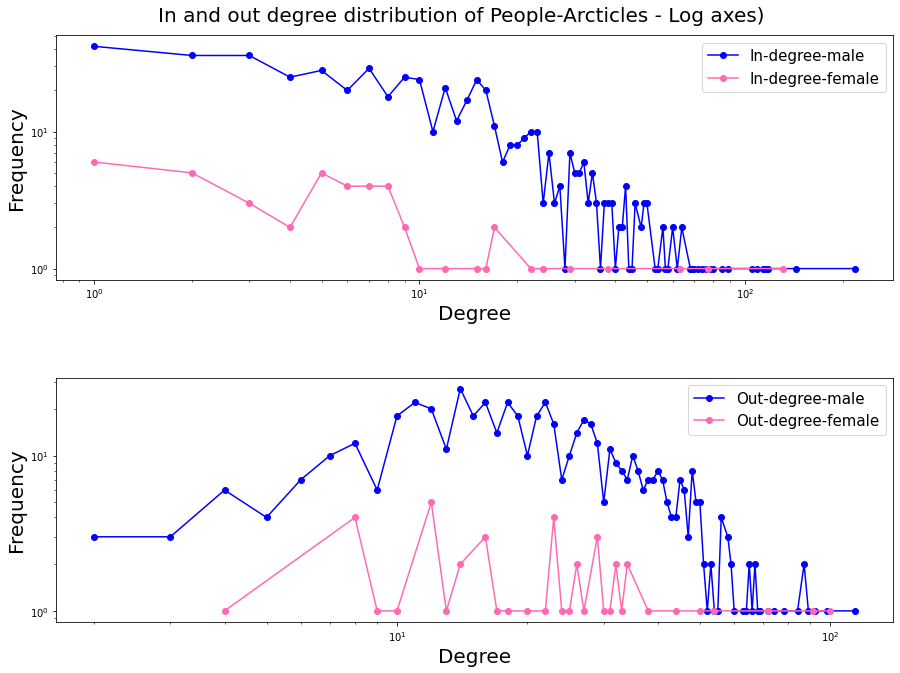

In [379]:
# degree distribution
# sns.catplot(data =people, y="nr_link_in", hue= "gender")
in_degree_male = people[people["gender"] == "male"]["nr_link_in"].value_counts().sort_index()
out_degree_male = people[people["gender"] == "male"]["nr_link_out"].value_counts().sort_index()
in_degree_female = people[people["gender"] == "female"]["nr_link_in"].value_counts().sort_index()
out_degree_female = people[people["gender"] == "female"]["nr_link_out"].value_counts().sort_index()


fig, axes = plt.subplots(2, 1, figsize = (15,10),gridspec_kw={'hspace': 0.4, 'wspace': 0.2})
fig.suptitle("In and out degree distribution of People-Arcticles - Log axes)", fontsize=20)
# axes[0][0].plot(range(len(in_degree_freq)), in_degree_freq, 'go-', label='In-degree')
axes[0].loglog(in_degree_male.index, in_degree_male, 'o-', label='In-degree-male',c = "blue") 
axes[0].set_xticks(in_degree_male.index)
axes[0].loglog(in_degree_female.index, in_degree_female, 'o-', label='In-degree-female', c= "hotpink") 
axes[1].loglog(out_degree_male.index, out_degree_male, 'o-', label='Out-degree-male',c = "blue") 
axes[1].loglog(out_degree_female.index, out_degree_female, 'o-', label='Out-degree-female', c= "hotpink") 
for x in range(0,axes.shape[0]):
        axes[x].set_xlabel('Degree', fontsize = 20)
        # axes[x].set_xticks([2,20, 200])
        axes[x].set_ylabel('Frequency', fontsize = 20)
        axes[x].legend(fontsize=15)
fig.subplots_adjust(top=0.94)
plt.show()